In [1]:
%load_ext autoreload
%autoreload 2
import os
#change current working directory to the parent directory
import sys

# Change working directory to ../ only if not already there
if not hasattr(sys, "_parent_dir_set"):
    parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
    if os.getcwd() != parent_dir:
        os.chdir(parent_dir)
    sys._parent_dir_set = parent_dir
else:
    parent_dir = sys._parent_dir_set
# Add parent_dir to sys.path only if not already present
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

import numpy as np
from SRtools import sr_mcmc as srmc
import argparse
from SRtools import config_lib as cl
from SRtools import deathTimesDataSet as dtds
import ast
from SRtools import readResults as rr
import corner
import matplotlib.pyplot as plt
import matplotlib
from SRtools import SRmodellib as sr
from SRtools import SRmodellib_lifelines as srl
import emcee
from SRtools import samples_utils as su
from SRtools import joint_posterior as jp
from SRtools import SR_hetro as srh
from SRtools import life_table as lt

In [2]:
from numpy import True_


configs_names = ['Sweden_F_1910_hetro','Denmark_F_1900_hetro','Denmark_F_1890_hetro']
data_config = 'Sweden_F_1910_hetro'

master_config_name = 'combined_human_F'

config_path = f"configurations_baysian.xlsx"

base_products_folder = os.path.join('analysis','products_baysian')
subfolder = None




summery_file_name = None
help_text ="joint posterior for combined human data"
apply_thresh = True


# POST_CREATED =False
SAVE_PRODUCTS =True
FAST = False
parallel = True
override = True
auto_thresh = True
thresh_max = 300



In [3]:
#get the name of current folder:
current_folder = os.path.basename(os.getcwd())

In [4]:
posts =[]
master_post_path = os.path.join(base_products_folder,'posteriors', master_config_name+'_post.csv')

for config_name in configs_names:
    config = cl.read_excel_config(config_path, config_name)
    cfg = cl.config_to_dict(config, mcmc_convert=True)
    test_mode = bool(int(cfg.get('test', 0)))
    if test_mode:
        test_idx = 1  # Use test index 0
        post_path = os.path.join(base_products_folder,'posteriors', config_name+f'_{test_idx}_post.csv')
    else:    
        post_path = os.path.join(base_products_folder,'posteriors', config_name+'_post.csv')
    # Make sure the posterior directory exists before anything else
    posterior_dir = os.path.join(base_products_folder, 'posteriors')




    post = su.Posterior.load_from_file(post_path)
    posts.append(post)
    #########################################################
    if config_name == data_config:
        data_config_post = post

        config_dict =post.config_params
        npeople = config_dict['npeople']
        t_end = config_dict['t_end']
        nwalkers = config_dict['nwalkers']
        nsteps = config_dict['nsteps']
        num_mcmc_steps = config_dict['n_mcmc_steps']
        metric = config_dict['metric']
        time_range = config_dict.get('time_range',None)
        time_step_multiplier = config_dict['time_step_multiplier']
        data_file = config_dict.get('data_file',None)
        seed_file = config_dict.get('seed_file',None)
        variations = config_dict.get('variations')
        prior = config_dict.get('prior')
        transform = config_dict.get('transform',True)
        index = config_dict.get('index',1)
        external_hazard = config_dict.get('external_hazard',None)
        if isinstance(external_hazard, str):
            external_hazard = ast.literal_eval(external_hazard)
        hetro = config_dict.get('hetro', False)
        submission_folder = config_dict['submission_folder']
        test_mode = bool(int(config_dict.get('test', 0)))
        n_tests = config_dict.get('n_tests', 1)
        ndims = config_dict.get('ndims', 4)
        dt = config_dict.get('dt',1)
        nbins = int(config_dict.get('nbins',100))
        TIME_UNIT = config_dict.get('TIME_UNIT','days')



        #all paths are in absolute paths (start with ~/). change all paths to be relative to the current folder 
        # (remove everything before the current folder name)
        submission_folder = submission_folder.split(current_folder)[-1]
        #remove the first / from the paths

        submission_folder = submission_folder[1:]

        # In test mode, adjust paths to use test index subfolder
        if test_mode:
            name = str(cfg.get('name'))
            # Store base submission folder for datasets path
            base_submission_folder = submission_folder
            # Modify submission_folder to point to test subfolder
            submission_folder = f"{submission_folder}/test_{test_idx}"
            # Modify data_file to point to dataset in test mode (datasets are at base submission level)
            datasets_folder = f"{base_submission_folder}/datasets"
            data_file = f"{datasets_folder}/{name}_dataset_{test_idx}.csv"
        else:
            data_file = data_file.split(current_folder)[-1]
            data_file = data_file[1:]
            
        h5_folder = f"{submission_folder}/h5_files"

In [5]:
if test_mode:
    test_str = f'_test_{test_idx}'
else:
    test_str = ''

config_name = master_config_name

if SAVE_PRODUCTS:
    Products_folder = base_products_folder

    if subfolder is not None:
        path = os.path.join(Products_folder,subfolder, config_name+test_str)
        results_path = os.path.join(Products_folder,'results_csvs',subfolder,config_name+test_str+'result_table.csv')
        path_days = os.path.join(Products_folder,'results_csvs_days',config_name+test_str+'result_table_days.csv')
    else:
        path = os.path.join(Products_folder, config_name)
        results_path = os.path.join(Products_folder,'results_csvs',config_name+test_str+'result_table.csv')
        path_days = os.path.join(Products_folder,'results_csvs_days',config_name+test_str+'result_table_days.csv')
    # Create all necessary directories if they don't exist
    os.makedirs(os.path.dirname(results_path), exist_ok=True)
    os.makedirs(os.path.dirname(path_days), exist_ok=True)
    os.makedirs(path, exist_ok=True)
else:
    results_path=None
    path_days=None
    path=None

if TIME_UNIT == 'days':
    scale = None
elif TIME_UNIT == 'hours':
    scale = 1/24
elif TIME_UNIT == 'years':
    scale = 365
elif TIME_UNIT == 'weeks':
    scale = 7
elif TIME_UNIT == 'generations':
    scale = 1/8
else:
    raise ValueError(f"Invalid TIME_UNIT: {TIME_UNIT}")



# print(f"Loading file from: {path}")

In [6]:
ds = dtds.dsFromFile(data_file, properties=['death dt'])
ds.external_hazard = external_hazard
eta = float(cfg.get('eta'))
beta = float(cfg.get('beta'))
epsilon = float(cfg.get('epsilon'))
xc = float(cfg.get('xc'))
seed_ExtH = cfg.get('ExtH',None)
if seed_ExtH is not None and seed_ExtH != '':
    seed_ExtH = float(seed_ExtH)
else:
    seed_ExtH = None
seed = [eta,beta,epsilon,xc,seed_ExtH]
seed = seed[0:ndims]
if transform:
    seed_trans = srmc.transform(seed)

In [7]:
samples_list = []
lnprobs_list = []
for pos in posts:
    samples = pos.samples
    if len(samples[0,:]) == 5:
        # Remove the external hazard from the samples array
        samples = samples[:, :-1]
    
    samples_list.append(samples)
    lnprobs_list.append(pos.lnprobs)

post = jp.JointPosterior(samples_list, lnprobs_list, nbins, log=True,config_params=config_dict,help_text=help_text)
if post_path is not None:
    post.save_to_file(master_post_path)


best_theta_trans = post.get_mode()


Processing unique samples for set 2: 100%|██████████| 2054/2054 [00:00<00:00, 558769.00it/s]


In [8]:
if test_mode:
    truths_trans =seed_trans
    truths = seed
else:
    truths_trans = best_theta_trans


In [9]:
labels_trans = ["$x_c/\\eta$","$\\beta/\\eta$","$x_c^2/\\epsilon$","$x_c$","EextH"]
labels_trans = labels_trans[0:4]

# 3. Posterior distributions of parameters

1d marginalizations of posterior distributions. we use a grid of size nbins=100-150

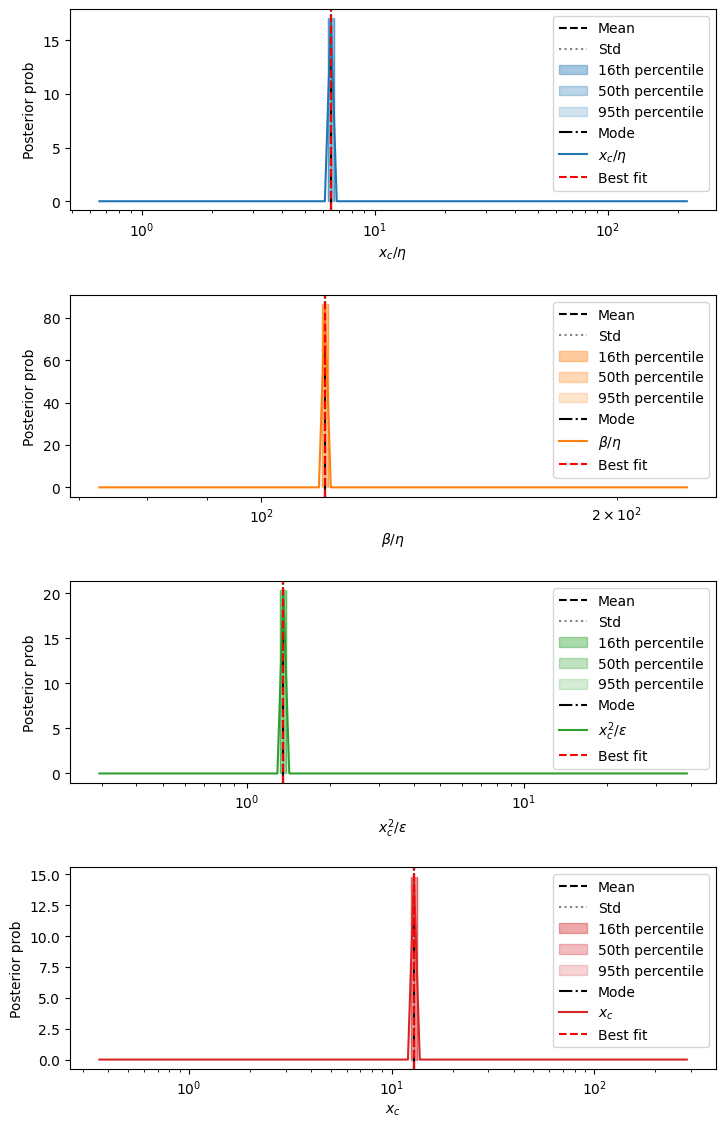

In [10]:
post.plot_1d_posteriors(labels=labels_trans, truths=truths_trans,scale='log',show_ln_prob=False,smooth_mode=False)

2D marginalizations of posterior distributions 

Creating corner plot:   0%|          | 0/4 [00:00<?, ?it/s]/Volumes/alon/navehr/SRtools/SRtools/samples_utils.py:474: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(X, Y, Z, **kwargs)
Creating corner plot: 100%|██████████| 4/4 [00:02<00:00,  1.34it/s]


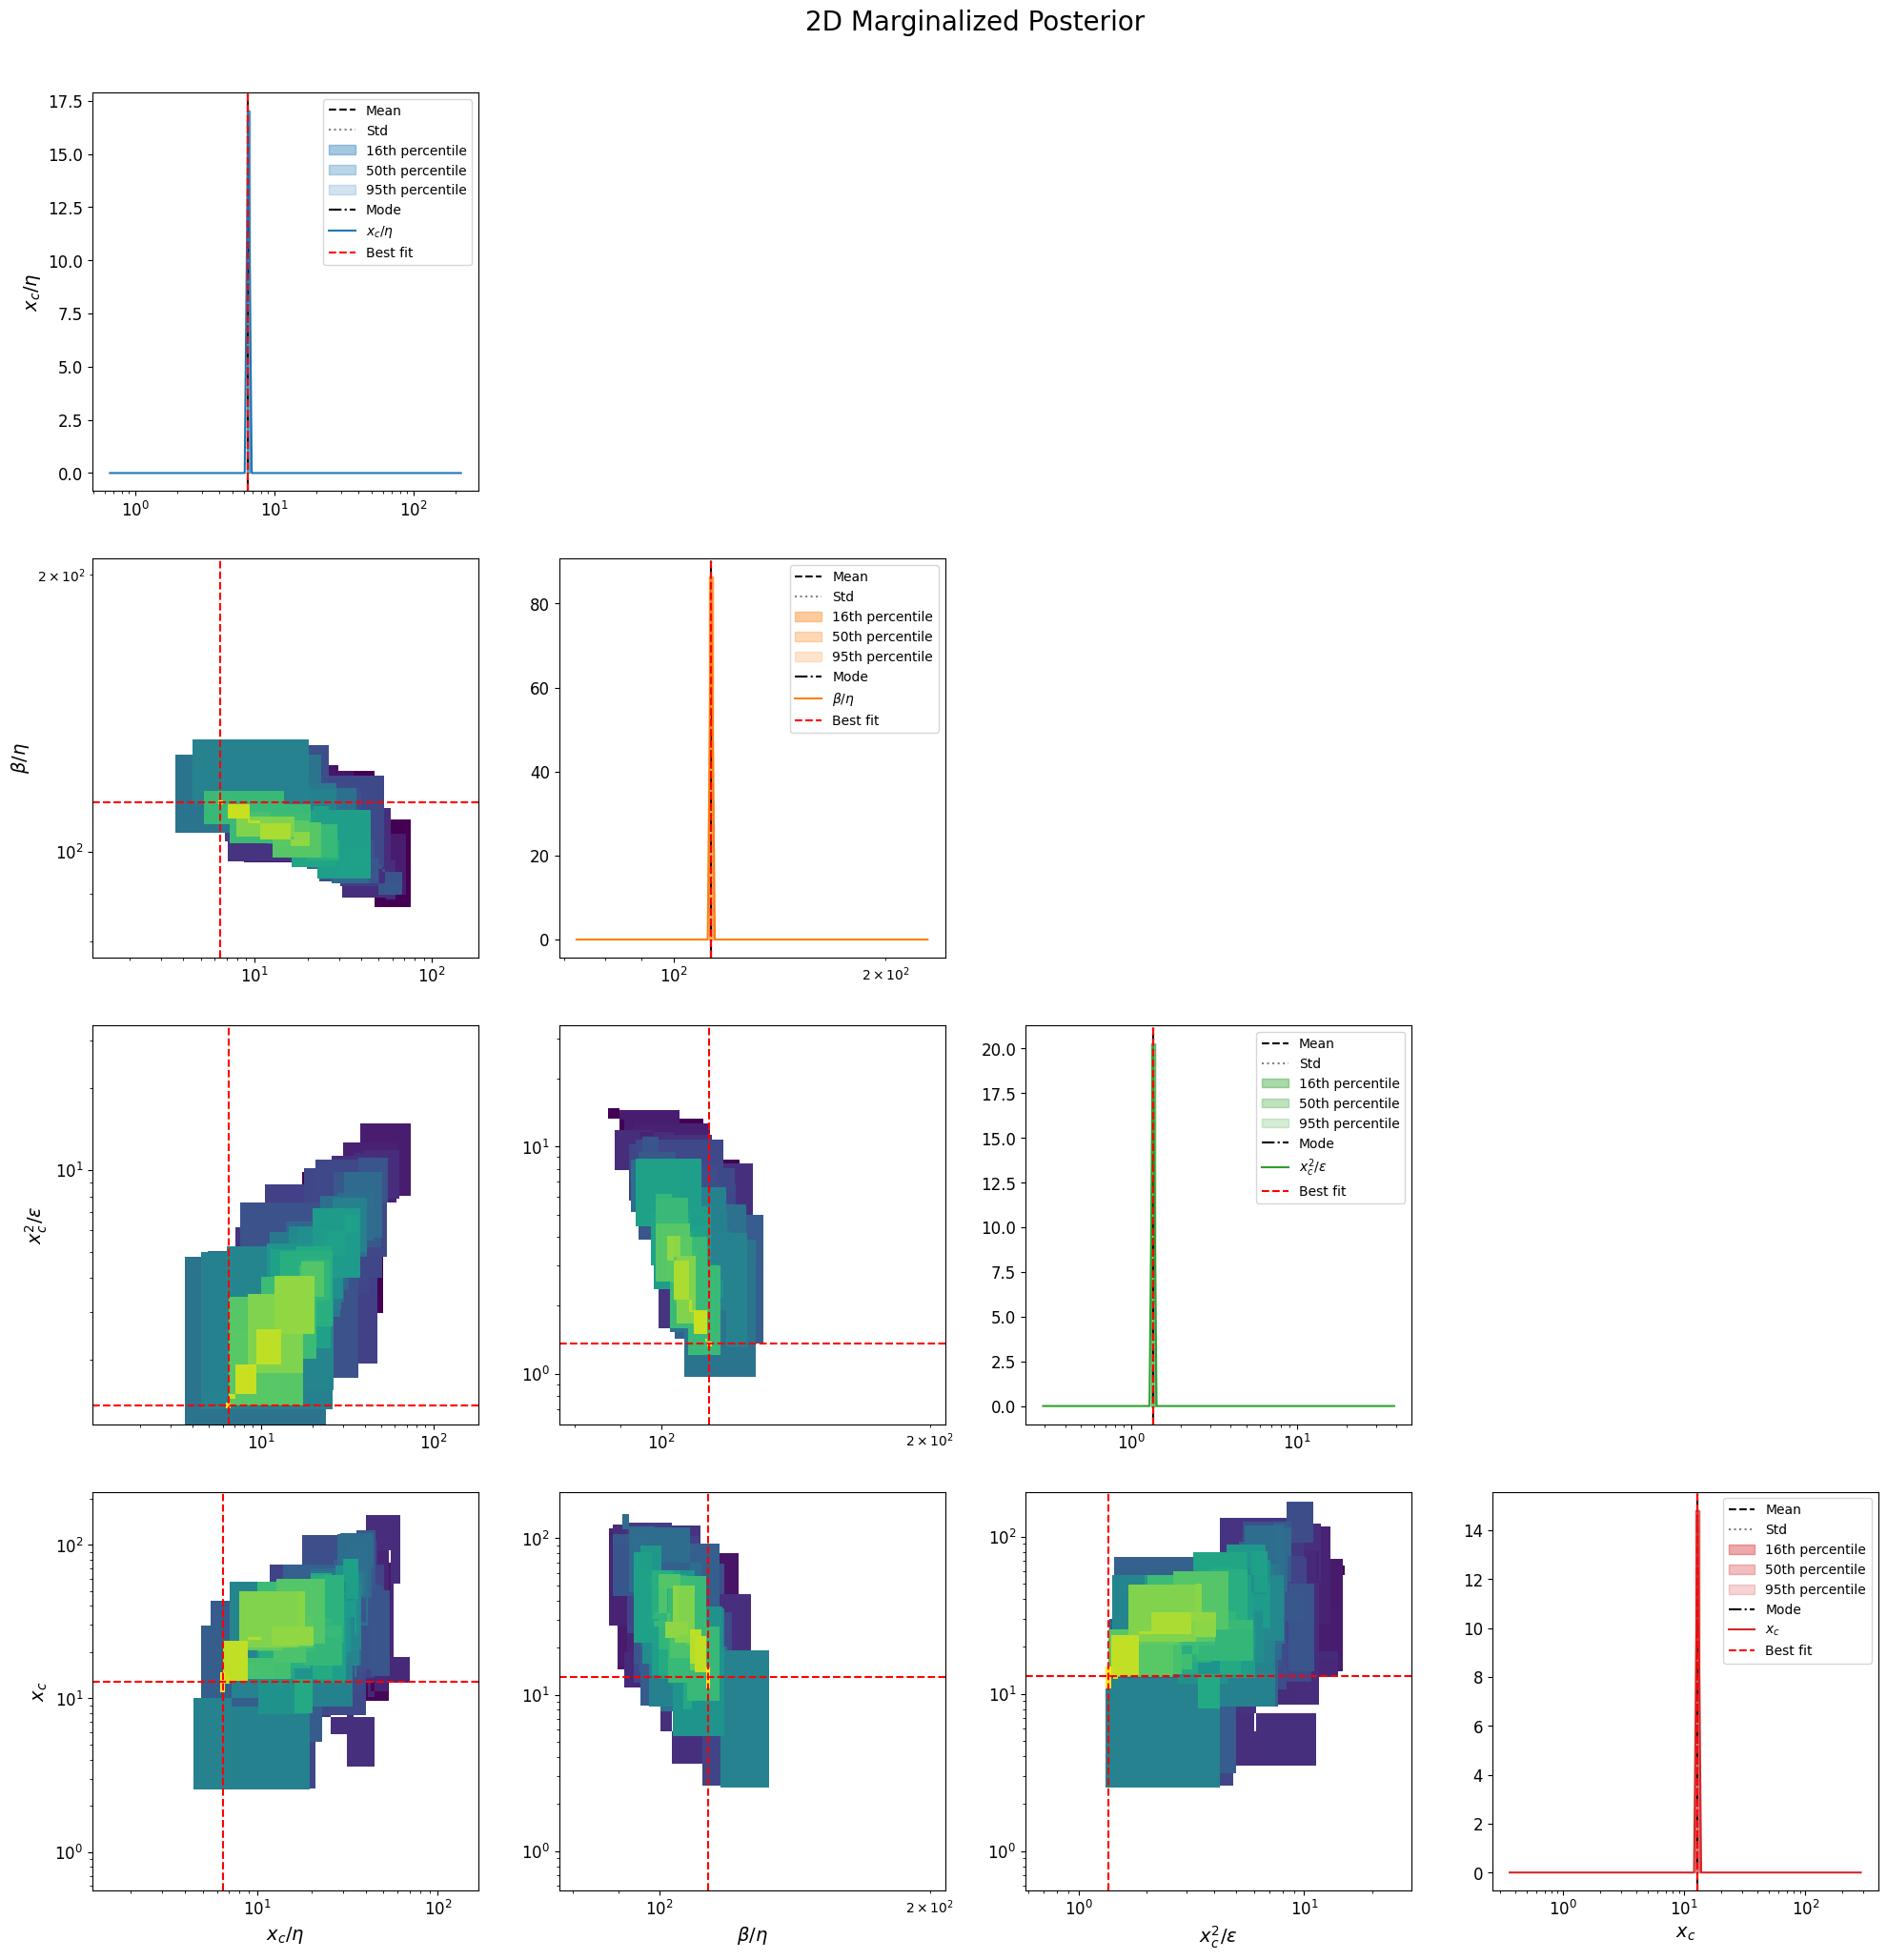

In [11]:
if not FAST:
    _=post.corner_plot(labels=labels_trans, truths=truths_trans,scale='log',show_ln_prob=False,norm='log',plot_type="pcolormesh")

In [12]:
fig =post.plot_posterior3D_interactive([0,1,2],labels=labels_trans, truths=np.log(truths_trans),truth_label="Best fit" )
# Save the figure using matplotlib's savefig instead of plotly's write_image
fig.show()
if SAVE_PRODUCTS:
    # Save the figure as HTML
    html_file_name = master_config_name+test_str+'_3D_plot'
    if subfolder is not None:
        html_file_name = os.path.join(subfolder, html_file_name)
    html_path = os.path.join(Products_folder, 'html_3d_plots', f'{html_file_name}.html')
    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(html_path), exist_ok=True)
    fig.write_html(html_path)

In [13]:
best_theta =srmc.inv_transform(best_theta_trans)


In [14]:
if ndims == 5:
    external_hazard_estimate = best_theta[-1]
else:
    external_hazard_estimate = None
best_sim = srh.getSrHetro(best_theta, nsteps=nsteps, npeople=npeople, time_step_multiplier=time_step_multiplier, t_end=t_end, external_hazard=external_hazard_estimate,hetro =hetro,parallel=parallel)
best_sim_no_ext_hazard = srh.getSrHetro(best_theta, nsteps=nsteps, npeople=npeople, time_step_multiplier=time_step_multiplier, t_end=t_end, external_hazard=None,hetro =hetro,parallel=parallel)

In [15]:
if SAVE_PRODUCTS:
    save_path = results_path
else:
    save_path = None
if test_mode:
    truth_df = seed_trans
else:
    truth_df =None
df=post.create_posterior_df(filepath=save_path, ds = [best_sim_no_ext_hazard,best_sim,ds], ds_labels=['best fit no ext hazard','best fit','data'],truth=truth_df)


Processing unique samples for set 2: 100%|██████████| 1869/1869 [00:00<00:00, 351043.58it/s]


In [16]:
#creating a new df with the results in days
if TIME_UNIT != 'days':
    df_days=post.create_posterior_df(filepath=path_days, ds = [best_sim_no_ext_hazard,best_sim,ds], ds_labels=['best fit no ext hazard','best fit','data'],rescale=scale,truth=truth_df)
else:
    df_days=df
    if path_days is not None:
        df_days.to_csv(path_days)


Rescaling the samples TIME by 365


Processing unique samples for set 2: 100%|██████████| 1855/1855 [00:00<00:00, 374077.31it/s]


# 4. Table of results

mode is the marginalized mode,
max_likwlihood is the sample with highest likelihood
mode_overall is the 4D posterior mode


In [17]:
df

,mean,std,mode,percentile_16,percentile_50,percentile_95,max_likelihood,mode_overall
xc/eta,6.473,"[0.000218, 0.000218]",6.864,"[6.665, 7.068]","[6.665, 7.068]","[6.665, 7.068]",6.396,6.473
beta/eta,113.176,"[0.000752, 0.000752]",110.584,"[109.946, 111.226]","[109.946, 111.226]","[109.946, 112.522]",112.717,113.176
xc^2/epsilon,1.357,"[3.83e-05, 3.83e-05]",1.425,"[1.391, 1.461]","[1.391, 1.461]","[1.391, 1.461]",1.38,1.357
xc,12.88,"[0.00199, 0.00199]",13.778,"[13.321, 14.25]","[13.321, 14.25]","[13.321, 14.25]",13.203,12.88
eta,2.048,"[1.52e-07, 1.52e-07]",2.18,"[2.113, 2.25]","[2.113, 2.25]","[1.985, 2.25]",2.064,2.048
beta,233.692,"[1.58e-05, 1.58e-05]",233.692,"[227.139, 240.435]","[227.139, 240.435]","[227.139, 240.435]",232.683,233.692
epsilon,135.151,"[2.28e-05, 2.28e-05]",117.236,"[109.19, 125.875]","[109.19, 125.875]","[109.19, 145.11]",126.286,135.151
sqrt(xc/eta),2.544,"[0.000128, 0.000128]",2.62,"[2.582, 2.659]","[2.582, 2.659]","[2.582, 2.659]",2.529,2.544
s= eta^0.5*xc^1.5/epsilon,0.551,"[3.43e-05, 3.43e-05]",0.572,"[0.561, 0.582]","[0.561, 0.582]","[0.561, 0.582]",0.546,0.551
beta*xc/epsilon,23.972,"[0.00172, 0.00172]",22.994,"[22.52, 23.478]","[22.52, 23.478]","[21.601, 23.478]",24.327,23.972


In [18]:
if SAVE_PRODUCTS:
    ####GO OVER THIS BEFORE SAVING!!!!!!!!!!!!###################################################
    import pandas as pd
    import SRtools.utils as ut
    summery_csv_base_name='summery'
    # Create paths for the three summary CSV files
    mode_summary_path = os.path.join(base_products_folder, f'{summery_csv_base_name}_mode.csv')
    max_likelihood_summary_path = os.path.join(base_products_folder, f'{summery_csv_base_name}_max_likelihood.csv')
    mode_overall_summary_path = os.path.join(base_products_folder, f'{summery_csv_base_name}_mode_overall.csv')

    # Get the relevant values from df_days
    file_name = config_name+test_str
    mode_values = df_days['mode'].copy()
    max_likelihood_values = df_days['max_likelihood'].copy()
    mode_overall_values = df_days['mode_overall'].copy()
    # Get the 95% confidence intervals from df_days
    ci_values = df_days['percentile_95'].copy()
    # Convert CI values to string representation
    ci_values = ci_values.apply(lambda x: f"[{x[0]}, {x[1]}]" if isinstance(x, (list, tuple, np.ndarray)) else x)



    # Add file name as column name
    mode_values = pd.DataFrame(mode_values.values, columns=[file_name], index=mode_values.index)
    mode_values[f'{file_name} 95% CI'] = ci_values
    max_likelihood_values = pd.DataFrame(max_likelihood_values.values, columns=[file_name], index=max_likelihood_values.index)
    mode_overall_values = pd.DataFrame(mode_overall_values.values, columns=[file_name], index=mode_overall_values.index)



    # Save the data
    ut.append_or_create_csv(mode_values, mode_summary_path,override=override)
    ut.append_or_create_csv(max_likelihood_values, max_likelihood_summary_path,override=override)
    ut.append_or_create_csv(mode_overall_values, mode_overall_summary_path,override=override)

    # If in test mode, also create an error CSV with specified columns, adding file_name to column headers
    if test_mode:
        error_columns = [
            'error_mode',
            'error_max_likelihood',
            'error_mean',
            'error_mode_overall',
            'ci95_size_pct',
            'in_percentile_16_CI',
            'in_percentile_50_CI',
            'in_percentile_95_CI',
            'in_std_CI',
        ]
        # Only select error columns that exist in df_days
        columns_present = [col for col in error_columns if col in df_days.columns]
        error_df_raw = df_days[columns_present].copy()
        # Create a MultiIndex column if more than one experiment, otherwise just use file_name as suffix
        error_df = error_df_raw.rename(columns={col: f"{file_name} {col}" for col in columns_present})
        error_csv_path = os.path.join(base_products_folder, f'{summery_csv_base_name}_error.csv')
        ut.append_or_create_csv(error_df, error_csv_path, override=True)
